# 1. Import and Install Dependencies

In [1]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

2023-05-28 11:16:39.857898: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model (to make our detection)
mp_drawing = mp.solutions.drawing_utils # Drawing utilities (to draw them)

In [3]:
def mediapipe_detection(image, model): #NOTA: image is a frame
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    """mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections"""
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    """# Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) """
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# Prova per verificare la presenza di landmark e catturare l'ultimo frame

In [ ]:
cap = cv2.VideoCapture(0) # Per accedere alla webcam
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read() #"Leggi un frame dalla webcam --> frame"

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [22]:
draw_landmarks(frame, results)

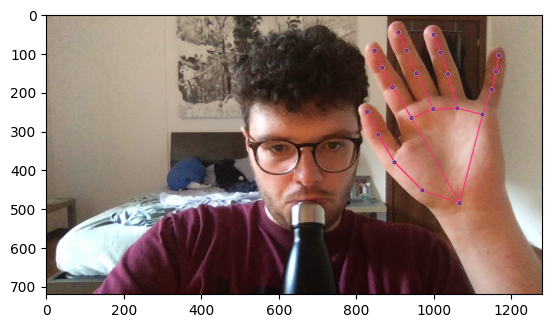

In [70]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [ ]:
len(results.left_hand_landmarks.landmark) #Numero di landmark

# 3. Extract Keypoint Values

In [6]:
def extract_keypoints(results):
    #pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    #face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    #Codice per ottenere la z reale
    
    #return np.concatenate([pose, face, lh, rh])
    return np.concatenate([lh, rh])

In [ ]:
result_test = extract_keypoints(results)
result_test.shape #126 elementi (21*3 mano destra + 21*3 mano sinistra)

# 4. Setup Folders for Collection

In [8]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['0','1', '2', '3','4','5','altro'])

# Thirty videos worth of data
no_sequences = 120

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 1

Creazione del folder che conterrà tutti i frame del dataset

In [ ]:
for action in actions: 
    #dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    dirmax=0
    for sequence in range(start_folder,no_sequences+start_folder):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(dirmax+sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [10]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, 'altro': 6}

In [11]:
sequences, labels = [], []
for action in actions:
    lista= np.array(os.listdir(os.path.join(DATA_PATH, action))) #0,1,2,3,4,5,altro accede ad ognuna di queste cartelle

    for j in range(len(lista)-1): #Elimina le cartelle che non presentano frame ('.DS_Store')
        if lista[j]=='.DS_Store':
            lista = np.delete(lista,j)

    for sequence in lista.astype(int):
        window = [] 
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [17]:
len(sequences) #840
len(window) #30
len(lista) #120
sequence_length #30

30

In [19]:
np.array(sequences).shape

(840, 30, 126)

In [18]:
np.array(labels).shape

(840,)

In [20]:
X = np.array(sequences)

In [21]:
X.shape

(840, 30, 126)

In [22]:
y = to_categorical(labels).astype(int)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [24]:
y_test.shape

(42, 7)

# Funzione per la visualizzazione della loss e accuracy dell'allenamento

In [25]:
import matplotlib.pyplot as plt

def loss_accuracy(history):
    h ="""h: output del modello"""

    # Estrazione della loss e dell'accuracy dalla cronologia dell'addestramento
    loss = history.history['loss']
    accuracy = history.history['categorical_accuracy']

    # Plot della loss
    plt.figure()
    plt.plot(loss, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss durante l\'addestramento')
    plt.legend()
    plt.show()

    # Plot dell'accuracy
    plt.figure()
    plt.plot(accuracy, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy durante l\'addestramento')
    plt.legend()
    plt.show()
    return 0

# 7. Build and Train LSTM Neural Network

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [27]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [147]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

Modello originale

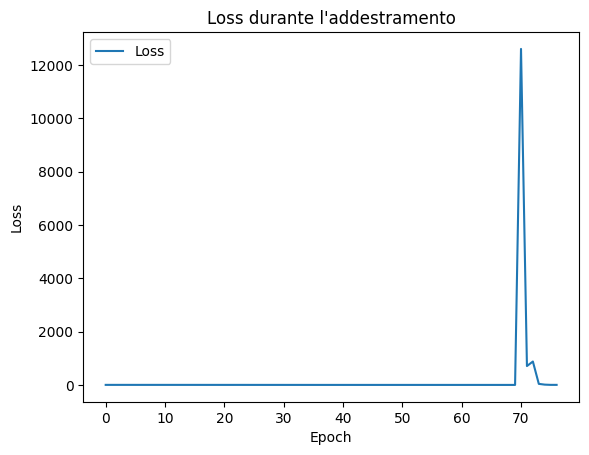

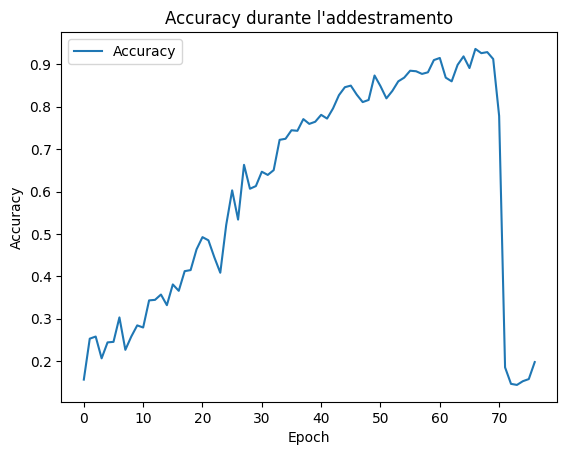

0

In [152]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback, early_stopping],verbose=0)
#model.summary()

loss_accuracy(history)

Modello 1 (variante)

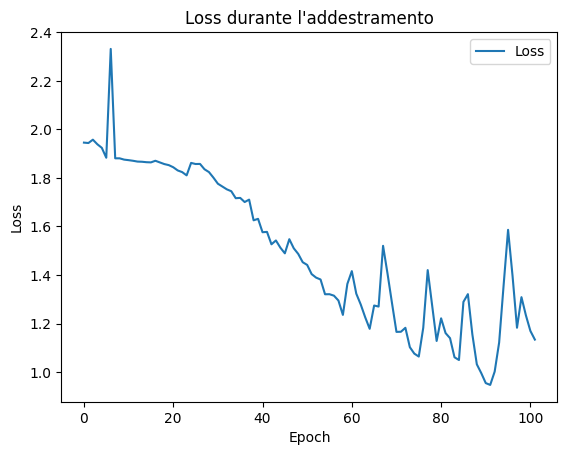

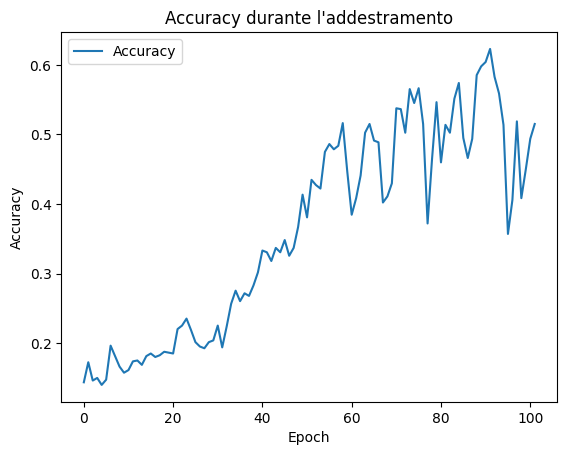

0

In [153]:
model_1 = Sequential()
model_1.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30, 126)))
model_1.add(LSTM(16, return_sequences=True, activation='relu'))
model_1.add(LSTM(8, return_sequences=False, activation='relu'))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(4, activation='relu'))
model_1.add(Dense(actions.shape[0], activation='softmax'))

model_1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history1 = history = model_1.fit(X_train, y_train, epochs=200, callbacks=[tb_callback, early_stopping],verbose=0)
#model_1.summary()

loss_accuracy(history1)

Modello 2 (variante) acccuracy test:0.66666

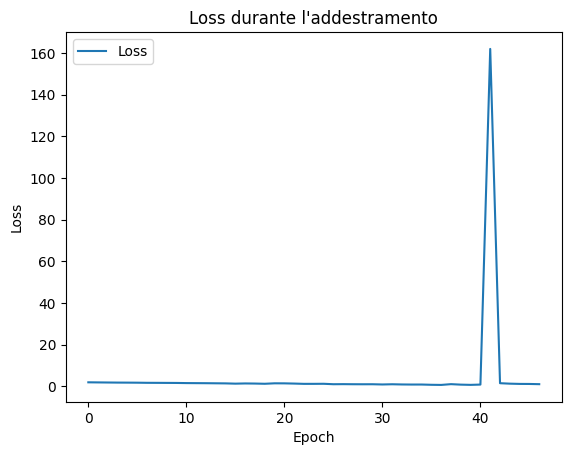

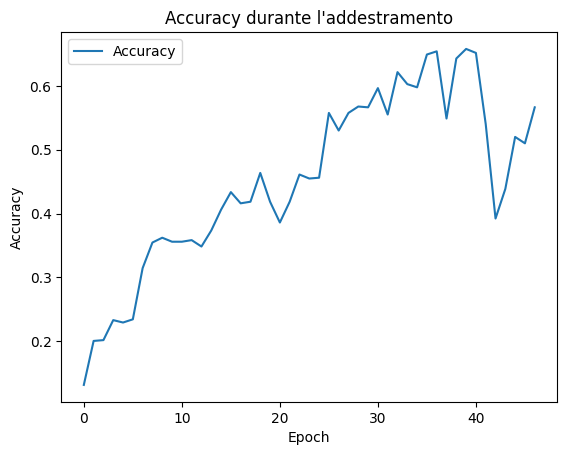

0

In [154]:
model_2 = Sequential()
model_2.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 126)))
model_2.add(LSTM(32, return_sequences=True, activation='relu'))
model_2.add(LSTM(16, return_sequences=False, activation='relu'))
model_2.add(Dense(16, activation='relu'))
model_2.add(Dense(8, activation='relu'))
model_2.add(Dense(actions.shape[0], activation='softmax'))

model_2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history2 = model_2.fit(X_train, y_train, epochs=200, callbacks=[tb_callback, early_stopping],verbose=0)
#model_2.summary()

loss_accuracy(history2)

Modello 3 (variante) accuracy test: 0.857

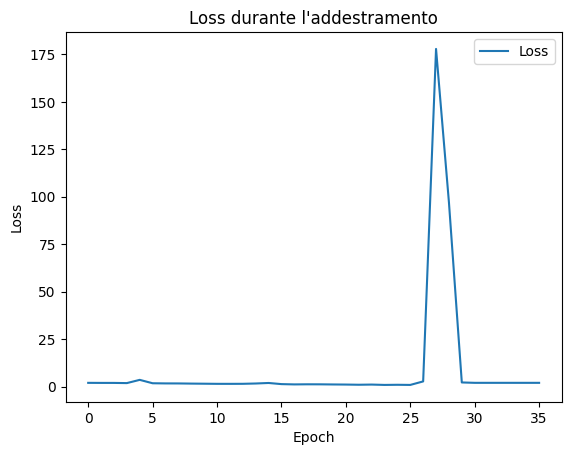

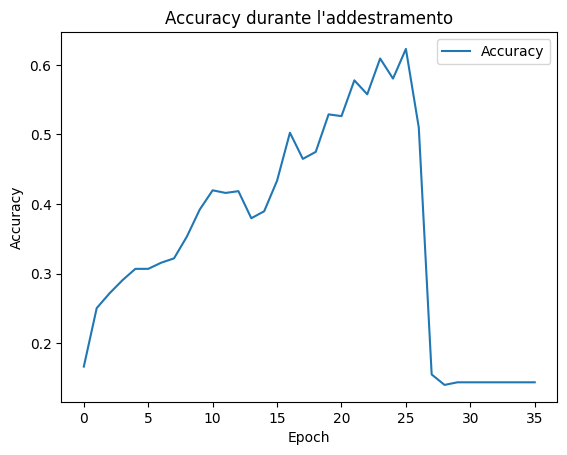

0

In [155]:
model_3 = Sequential()
model_3.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30, 126)))
model_3.add(LSTM(64, return_sequences=True, activation='relu'))
model_3.add(LSTM(32, return_sequences=False, activation='relu'))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(actions.shape[0], activation='softmax'))

model_3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history3 = model_3.fit(X_train, y_train, epochs=200, callbacks=[tb_callback, early_stopping],verbose=0)
#model_3.summary()

loss_accuracy(history3)

Tra i tre modelli sopra sembra che il più promettente sia il model_3. Cerchiamo di migliorarlo al fine di aumentare le performance

Aumeto complessità del modello

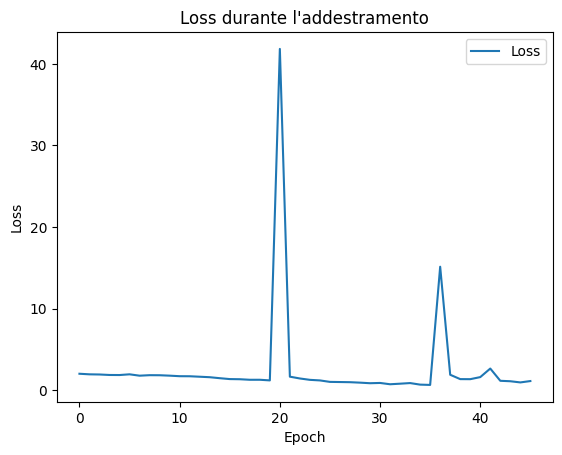

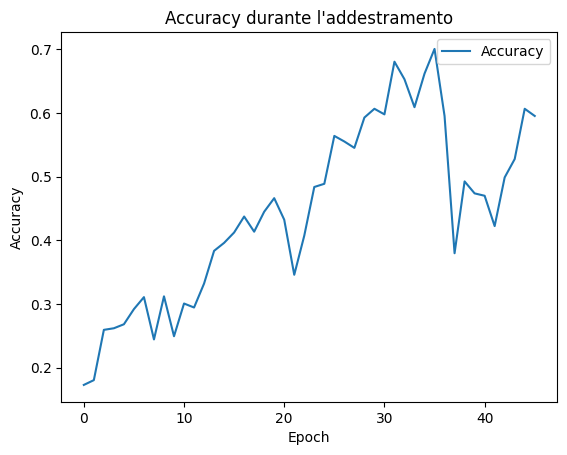

0

In [156]:
model_3_1 = Sequential()
model_3_1.add(LSTM(256, return_sequences=True, activation='relu', input_shape=(30, 126)))
model_3_1.add(LSTM(128, return_sequences=True, activation='relu'))
model_3_1.add(LSTM(64, return_sequences=False, activation='relu'))
model_3_1.add(Dense(64, activation='relu'))
model_3_1.add(Dense(32, activation='relu'))
model_3_1.add(Dense(actions.shape[0], activation='softmax'))

model_3_1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history3_1 = model_3_1.fit(X_train, y_train, epochs=200, callbacks=[tb_callback, early_stopping],verbose=0)
#model_3_1.summary()

loss_accuracy(history3_1)

Aggiungere regolarizzazione

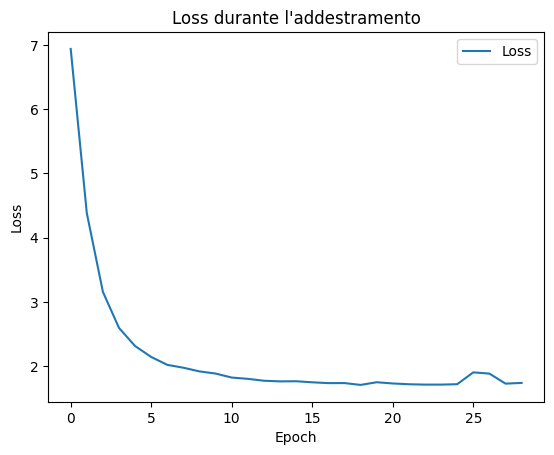

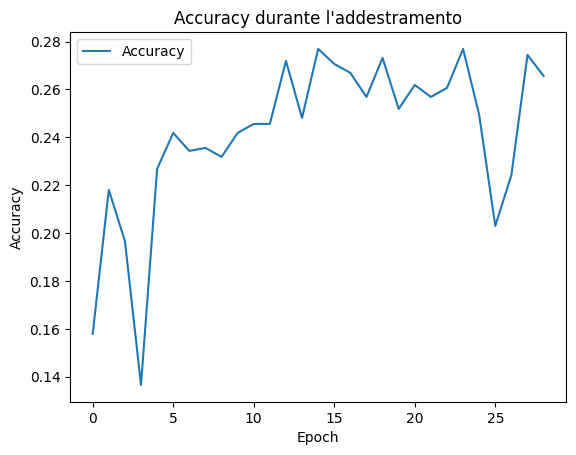

0

In [157]:
from tensorflow.keras import regularizers

model_3_2 = Sequential()
model_3_2.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30, 126), kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01)))
model_3_2.add(LSTM(64, return_sequences=True, activation='relu', kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01)))
model_3_2.add(LSTM(32, return_sequences=False, activation='relu', kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01)))
model_3_2.add(Dense(32, activation='relu'))
model_3_2.add(Dense(16, activation='relu'))
model_3_2.add(Dense(actions.shape[0], activation='softmax'))

model_3_2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history3_2 = model_3_2.fit(X_train, y_train, epochs=200, callbacks=[tb_callback, early_stopping],verbose=0)
#model_3_2.summary()

loss_accuracy(history3_2)


# 8. Make Predictions

In [134]:
res = model_3.predict(X_test)

2/2 [==============================] - 0s 10ms/step


In [126]:
print (f"Esempio di predizione sul test")
print(f"Classe reale: {np.argmax(y_test[3])}")
print(f"Classe predetta: {np.argmax(res[3])}")


Esempio di predizione sul test
Classe reale: 5
Classe predetta: 5


# 9. Save Weights

In [112]:
model.save('action.h5')

In [ ]:
import pickle
with open('history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

In [14]:
model.load_weights('action.h5')

In [ ]:
with open('history.pickle', 'rb') as file:
    history = pickle.load(file)

# 10. Evaluation using Confusion Matrix and Accuracy

In [127]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [143]:
yhat = model_3.predict(X_test)

2/2 [==============================] - 0s 12ms/step


In [144]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [146]:
accuracy_score(ytrue, yhat)

0.7380952380952381

# 11. Test in Real Time

In [113]:
from scipy import stats

In [114]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()